In [1]:
import json

training_datas = []

with open("D:\\appdata\\git\\gui-sys\\os-gensis\\os_genesis_web_training.jsonl", "r") as f:
    for line in f:
        data = json.loads(line)
        training_datas.append(data)

len(training_datas)

7494

In [2]:
trajs = []
temp_traj = []
last_instruction = ""

for data in training_datas:
    user_message = data['conversations'][0]['value']
    # 对于每一行，如果开头为 Instruction: ，单独拿出来
    for line in user_message.split('\n'):
        if line.startswith('Instruction: '):
            if line != last_instruction:
                if temp_traj:
                    trajs.append(temp_traj)
                    temp_traj = []
                temp_traj.append(data)
                last_instruction = line
            else:
                temp_traj.append(data)
            
            break

trajs.append(temp_traj)
len(trajs)

1284

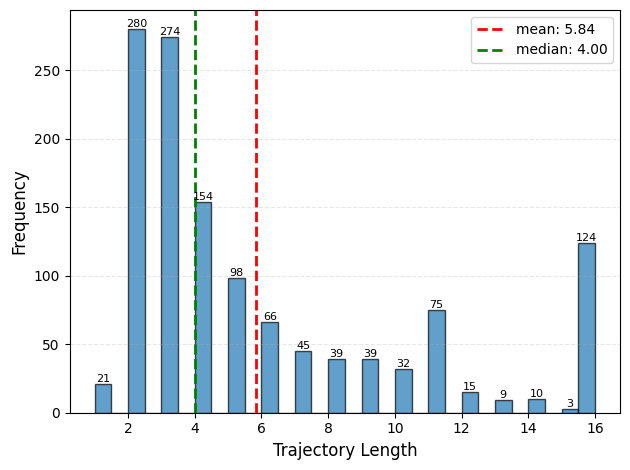

总轨迹数: 1284
平均长度: 5.84
中位数长度: 4.00
最小长度: 1
最大长度: 16


In [3]:
# 绘图，统计每个traj的length

from matplotlib import pyplot as plt
import numpy as np

lengths = [len(traj) for traj in trajs]

# 绘制直方图并获取返回值
n, bins, patches = plt.hist(lengths, bins=30, edgecolor='black', alpha=0.7)

# 在每个柱子上标注数量（只标注非零的柱子）
for i, (count, patch) in enumerate(zip(n, patches)):
    if count > 0:  # 只标注有数据的柱子
        # 获取柱子的中心位置
        x = (patch.get_x() + patch.get_width() / 2)
        y = patch.get_height()
        # 在柱子上方标注数量
        plt.text(x, y, f'{int(count)}', 
                ha='center', va='bottom', fontsize=8, rotation=0)

# 添加标题和标签
plt.xlabel('Trajectory Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 添加统计信息
mean_len = np.mean(lengths)
median_len = np.median(lengths)
plt.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'mean: {mean_len:.2f}')
plt.axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'median: {median_len:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"总轨迹数: {len(trajs)}")
print(f"平均长度: {mean_len:.2f}")
print(f"中位数长度: {median_len:.2f}")
print(f"最小长度: {min(lengths)}")
print(f"最大长度: {max(lengths)}")

In [4]:
removed_img_training_datas = []


for data in training_datas:
    # 对于 data['conversations'][0]['value']，如果第一行是 <image>，则删除该行，deep copy data，并添加到removed_img_training_datas中
    if data['conversations'][0]['value'].startswith('<image>'):
        temp_data = {}
        temp_data['messages'] = []
        lines = data['conversations'][0]['value'].split('\n')

        temp_data['messages'].append({
            "role": "user",
            "content": '\n'.join(lines[1:])
        })

        temp_data['messages'].append({
            "role": "assistant",
            "content": data['conversations'][1]['value']
        })

        if not data['conversations'][1]['value']:
            print(f"No action found for data: {data['id']}")
            continue

        removed_img_training_datas.append(temp_data)

len(removed_img_training_datas)

No action found for data: webarena_task_60
No action found for data: webarena_task_71
No action found for data: webarena_task_88
No action found for data: webarena_task_97
No action found for data: webarena_task_108
No action found for data: webarena_task_112
No action found for data: webarena_task_119
No action found for data: webarena_task_137
No action found for data: webarena_task_141
No action found for data: webarena_task_157
No action found for data: webarena_task_179
No action found for data: webarena_task_220
No action found for data: webarena_task_246
No action found for data: webarena_task_257
No action found for data: webarena_task_278
No action found for data: webarena_task_283
No action found for data: webarena_task_300
No action found for data: webarena_task_311
No action found for data: webarena_task_327
No action found for data: webarena_task_343
No action found for data: webarena_task_359
No action found for data: webarena_task_375
No action found for data: webarena_t

7197

In [5]:
# with open("D:\\appdata\\git\\gui-sys\\os-gensis\\os_genesis_web_training_plannings.jsonl", "w") as f:
#     for data in removed_img_training_datas:
#         f.write(json.dumps(data) + '\n')

In [12]:


import re

action_training_datas = []

user_prompt_template = """You are an intelligent agent completing web-based tasks. I will provide you with available actions, a screenshot with its corresponding accessibility tree, and a low-level thought.

**Available Actions**  
- `click [id]`: This action clicks on an element with a specific id on the webpage.
- `type [id] [content] [press_enter_after=0|1]`: Use this to type the content into the field with id. By default, the "Enter" key is pressed after typing unless press_enter_after is set to 0.
- `hover [id]`: Hover over an element with id.
- `press [key_comb]`:  Simulates the pressing of a key combination on the keyboard (e.g., Ctrl+v).
- `scroll [direction=down|up]`: Scroll the page up or down. 
- `new_tab`: Open a new, empty browser tab.
- `tab_focus [tab_index]`: Switch the browser's focus to a specific tab using its index.
- `close_tab`: Close the currently active tab. 
- `goto [url]`: Navigate to a specific URL.
- `go_back`: Navigate to the previously viewed page.
- `go_forward`: Navigate to the next page (if a previous 'go_back' action was performed).
- `stop [answer]`: Issue this action when you believe the task is complete. If the objective is to find a text-based answer, provide the answer in the bracket. If you believe the task is impossible to complete, provide the answer as "N/A" in the bracket.

{a11y_tree}
Low-level thought: {low_level_thought}

Please generate the action inside ˋˋˋˋˋˋ for the next step."""

for data in training_datas:
    lines = data['conversations'][0]['value'].split('\n')
    # 从开头为 Accessibility tree: 的行开始，到下一个以 Action History: 开头的行结束，获取中间的内容
    a11y_tree_list = []
    a11y_flag = False
    for line in lines:
        if line.startswith('Accessibility tree:'):
            a11y_flag = True
        elif line.startswith('Action History:'):
            a11y_flag = False
        
        if a11y_flag:
            a11y_tree_list.append(line)

    a11y_tree = '\n'.join(a11y_tree_list)

    # 关于 low_level_thought，从 data['conversations'][1]['value'] 中提取，找到 “In summary, the next action I will perform is” 前面的内容
    try:
        if not data['conversations'][1]['value']:
            print(f"No action found for data: {data['id']}")
            continue

        # if "I'm unable to watch or" in data['conversations'][1]['value']:
        #     print(f"No action found for data: {data['id']}")
        #     continue

        # if "I'm unable to assist with sharing posts" in data['conversations'][1]['value']:
        #     print(f"No action found for data: {data['id']}")
        #     continue

        # if "I'm unable to assist" in data['conversations'][1]['value']:
        #     print(f"No action found for data: {data['id']}")
        #     continue


        low_level_thought = data['conversations'][1]['value'].split('In summary, the next action I will perform is')[0]
        action_str = data['conversations'][1]['value'].split('In summary, the next action I will perform is')[1]

        # 找到 `````` 包裹的部分
        action_match = re.search(r'```(.*?)```', action_str, re.DOTALL)
        if action_match:
            action = action_match.group(1).strip()
        else:
            action = action_str.strip()

        action = "```" + action + "```"
    except:
        # raise ValueError(f"No low-level thought found for data: {data['conversations'][1]['value']}")
        print(f"can not find action for {data['id']}, skip....")
        continue

    temp_data = {}
    temp_data['messages'] = []
    temp_data['messages'].append({
        "role": "user",
        "content": user_prompt_template.format(a11y_tree=a11y_tree, low_level_thought=low_level_thought)
    })
    temp_data['messages'].append({
        "role": "assistant",
        "content": action
    })
    action_training_datas.append(temp_data)


len(action_training_datas)


No action found for data: webarena_task_60
No action found for data: webarena_task_71
No action found for data: webarena_task_88
No action found for data: webarena_task_97
No action found for data: webarena_task_108
No action found for data: webarena_task_112
No action found for data: webarena_task_119
can not find action for webarena_task_129, skip....
No action found for data: webarena_task_137
No action found for data: webarena_task_141
No action found for data: webarena_task_157
No action found for data: webarena_task_179
No action found for data: webarena_task_220
No action found for data: webarena_task_246
No action found for data: webarena_task_257
No action found for data: webarena_task_278
No action found for data: webarena_task_283
No action found for data: webarena_task_300
No action found for data: webarena_task_311
No action found for data: webarena_task_327
No action found for data: webarena_task_343
No action found for data: webarena_task_359
No action found for data: we

7175

In [17]:
with open("D:\\appdata\\git\\gui-sys\\os-gensis\\os_genesis_web_training_actions.jsonl", "w") as f:
    for data in action_training_datas:
        f.write(json.dumps(data) + '\n')

In [15]:
data = action_training_datas[501]
print(data['messages'][0]['content'])

You are an intelligent agent completing web-based tasks. I will provide you with available actions, a screenshot with its corresponding accessibility tree, and a low-level thought.

**Available Actions**  
- `click [id]`: This action clicks on an element with a specific id on the webpage.
- `type [id] [content] [press_enter_after=0|1]`: Use this to type the content into the field with id. By default, the "Enter" key is pressed after typing unless press_enter_after is set to 0.
- `hover [id]`: Hover over an element with id.
- `press [key_comb]`:  Simulates the pressing of a key combination on the keyboard (e.g., Ctrl+v).
- `scroll [direction=down|up]`: Scroll the page up or down. 
- `new_tab`: Open a new, empty browser tab.
- `tab_focus [tab_index]`: Switch the browser's focus to a specific tab using its index.
- `close_tab`: Close the currently active tab. 
- `goto [url]`: Navigate to a specific URL.
- `go_back`: Navigate to the previously viewed page.
- `go_forward`: Navigate to the n

In [16]:
print(data['messages'][1]['content'])

```click [2059]```
